In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_parquet("data/raw/france.parquet")
data.dropna(axis=0, how='any', inplace=True)

position = pd.read_csv("data/raw/postesSynop.csv", sep=";")

Id = position["ID"].astype(str)
for i in range(len(Id)):
    if len(Id[i]) < 5:
        Id[i] = '0' + Id[i]

production = pd.read_parquet("data/raw/franceagrimer-rdts-surfs-multicrops.parquet")
production = production.drop(production[production["n_dep"] == "2A"].index)
production = production.drop(production[production["n_dep"] == "2B"].index)
production = production.drop(production[production["n_dep"].astype(int) > 95].index)

provinces = {7005: 80, 7015: 59, 7020: 50, 7027: 14, 7037: 76, 
             7072: 51, 7110: 29, 7117: 22, 7130: 35, 7139: 61, 
             7149: 91, 7168: 10, 7181: 54, 7190: 67, 7207: 56, 
             7222: 44, 7240: 37, 7255: 18, 7280: 21, 7299: 68, 
             7314: 17, 7335: 86, 7434: 87, 7460: 63, 7471: 43, 
             7481: 69, 7510: 33, 7535: 46, 7558: 12, 7577: 26, 
             7591: 5,  7607: 40, 7621: 65, 7627: 9,  7630: 31, 
             7643: 34, 7650: 13, 7661: 83, 7690: 6,  7747: 66, 67005: 10}

crops = production["crop"].unique()
stations = data["id_sta"].unique()

In [3]:
lr = LinearRegression()

# Single element prediction

In [4]:
def init_x(data_list, data_name):
    for i in stations:
        if i in provinces:
            data_station = data[data["id_sta"] == i]
            year_position = 0

            for j in range(2017, 2023):
                one_data = 0
                for k in range(year_position, len(data_station)):
                    if data_station.index[k].year == j:
                        one_data += data_station[data_name][k]
                    else:
                        year_position = k
                        break
                data_list[str(provinces[i]) + "_" + str(j)] = one_data

In [5]:
def init_y(data_list):
    for i in data_list:
        n_dep0, year = i.split('_')
        r_year = production['n_dep'].map(lambda x : x == n_dep0)
        r_crop = production['crop'].map(lambda x : x == crop)
        rdt = production[r_year & r_crop]["rdt_" + year].values
        if rdt.size > 0:
            if rdt[0]:
                total_rdt[i] = rdt[0]

In [6]:
def init_list(data_list):
    temp_data_list = []
    temp_rdt_list = []

    for i in total_rdt:
        if i in data_list:
            temp_data_list.append(np.array([data_list[i]]))
            temp_rdt_list.append(total_rdt[i])

    temp_data_list = np.array(temp_data_list)
    temp_rdt_list = np.array(temp_rdt_list)
    
    return temp_data_list, temp_rdt_list

In [7]:
def init(data_list):
    init_y(data_list)
    return init_list(data_list)

In [8]:
def predict_zero():
    predict_zero = rdt_array.mean()
    
    RMSE = math.sqrt(((predict_zero - rdt_array) ** 2).sum() / len(rdt_array))
    rRMSE = RMSE / rdt_array.mean()
    
    return rRMSE

In [9]:
def predict_n(n, times):
    if n == 0:
        return predict_zero(), 0.0, rdt_array.mean()

    sum_RMSE = 0
    coef = np.array([0.0 for i in range(n)])
    intercept = 0.0
    
    for i in range(times):
        X_train, X_test, y_train, y_test = train_test_split(data_array, rdt_array, test_size=0.2)
        X_train_n = X_train
        X_test_n = X_test
        for i in range(2, n + 1):
            X_train_n = np.concatenate([X_train ** i, X_train_n], axis=1)
            X_test_n = np.concatenate([X_test ** i, X_test_n], axis=1)
        
        lr.fit(X_train_n, y_train)
        coef += lr.coef_
        intercept += lr.intercept_
        y_predict_n = lr.predict(X_test_n)
        
        RMSE = math.sqrt(((y_predict_n - y_test) ** 2).sum() / len(y_test))
        rRMSE = RMSE / y_test.mean()
        
        sum_RMSE += rRMSE

    return sum_RMSE / times, coef / times, intercept / times 

In [10]:
def test_degree_n(times):
    degree = np.linspace(start, end, end - start + 1)
    
    for i in degree:
        result = predict_n(i.astype(int), times)
        rRMSE_degree[crop + "_" + i.astype(int).astype(str)] = result[0]
        coeffs[crop + "_" + i.astype(int).astype(str)] = result[1]
        intercepts[crop + "_" + i.astype(int).astype(str)] = result[2]

In [11]:
def draw():
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    plt.xticks(np.arange(start, end + 1, 1))
    
    for crop in crops:
        rRMSE_plot = []
        x_plot = np.linspace(start, end, end + 1)
        for i in range(start, end - start + 1):
            rRMSE_plot.append(rRMSE_degree[crop + "_" + str(i)])
        plt.plot(x_plot, rRMSE_plot)
    plt.legend(crops, loc=1)

## rr24

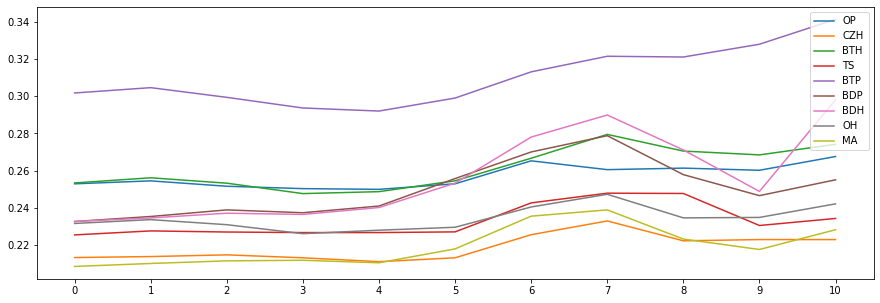

In [12]:
start = 0
end = 10
times = 1000
total_rain = {}

rRMSE_degree = {}
coeffs = {}
intercepts = {}

init_x(total_rain, "rr24")

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(total_rain)

    test_degree_n(times)

draw()

In [13]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(start, end + 1):
        temp_list.append(rRMSE_degree[crop + "_" + str(i)])
    best_predict[crop + "_" + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP_4': 0.24995213770977356,
 'CZH_4': 0.21109031651802512,
 'BTH_3': 0.24767364710354725,
 'TS_0': 0.2254771996904205,
 'BTP_4': 0.29203304808309805,
 'BDP_0': 0.23267610695447274,
 'BDH_0': 0.23267610695447274,
 'OH_3': 0.22614095729253425,
 'MA_0': 0.20852417057938513}

In [14]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP_4': array([ 7.96535861e-11, -1.61353488e-07,  6.07666978e-05,  2.55688641e-02]),
 'CZH_4': array([-6.34129469e-11,  1.97608809e-07, -2.09716790e-04,  8.15093712e-02]),
 'BTH_3': array([ 8.26698563e-08, -1.96524068e-04,  1.31324475e-01]),
 'TS_0': 0.0,
 'BTP_4': array([ 1.04507226e-10, -1.75359908e-07, -4.94986200e-06,  8.98998199e-02]),
 'BDP_0': 0.0,
 'BDH_0': 0.0,
 'OH_3': array([ 6.79890431e-08, -1.62743268e-04,  1.11544150e-01]),
 'MA_0': 0.0}

In [15]:
best_intercepts = {}

for inter in intercepts:
    if inter in best_predict:
        best_intercepts[inter] = intercepts[inter]
        
best_intercepts

{'OP_4': 40.00114136327751,
 'CZH_4': 22.93751804772806,
 'BTH_3': 41.819071186710225,
 'TS_0': 23.18595505617978,
 'BTP_4': 36.921266688509164,
 'BDP_0': 49.28058252427186,
 'BDH_0': 49.28058252427186,
 'OH_3': 40.02190088900575,
 'MA_0': 84.95027027027027}

In [16]:
best_predict_degree = {}

for i in best_predict:
    name, degree = i.split("_")
    best_predict_degree[name] = degree

best_predict_degree

{'OP': '4',
 'CZH': '4',
 'BTH': '3',
 'TS': '0',
 'BTP': '4',
 'BDP': '0',
 'BDH': '0',
 'OH': '3',
 'MA': '0'}

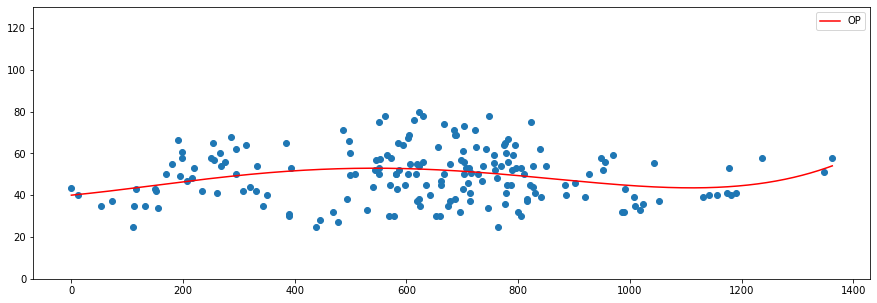

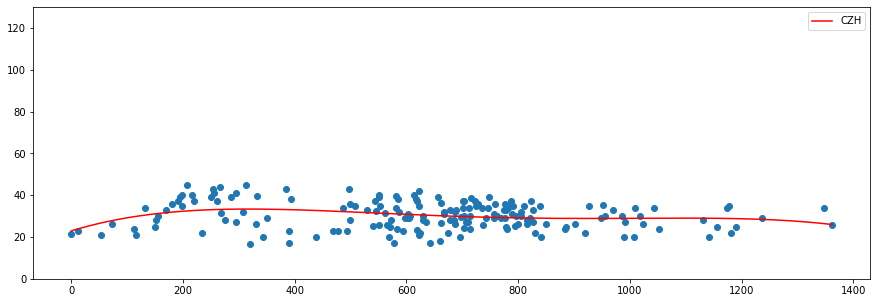

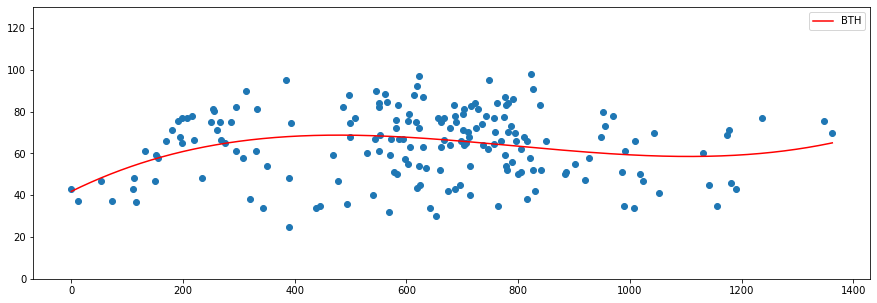

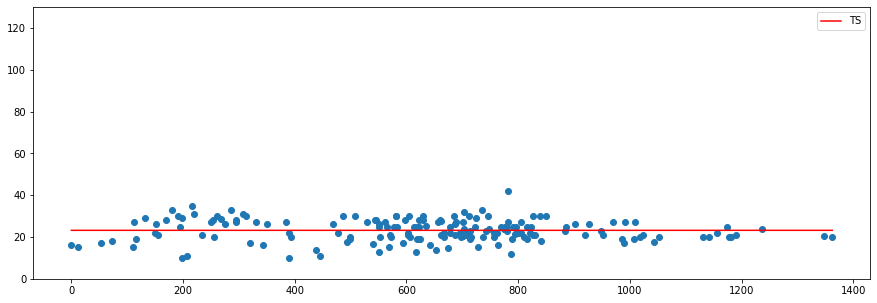

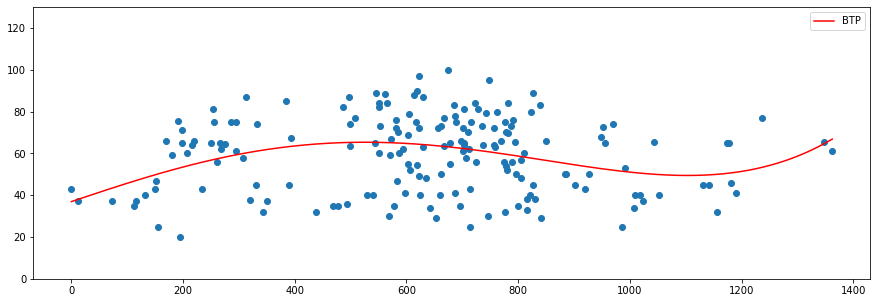

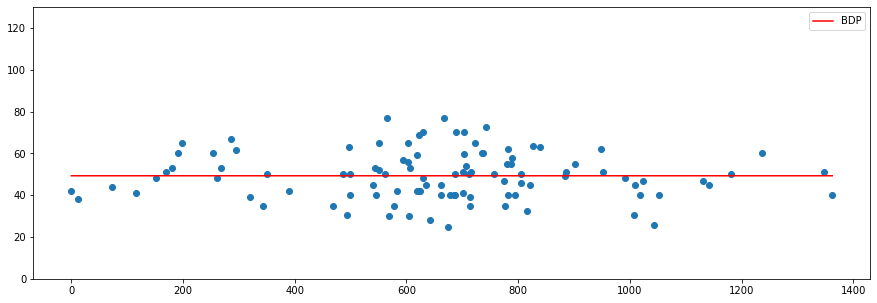

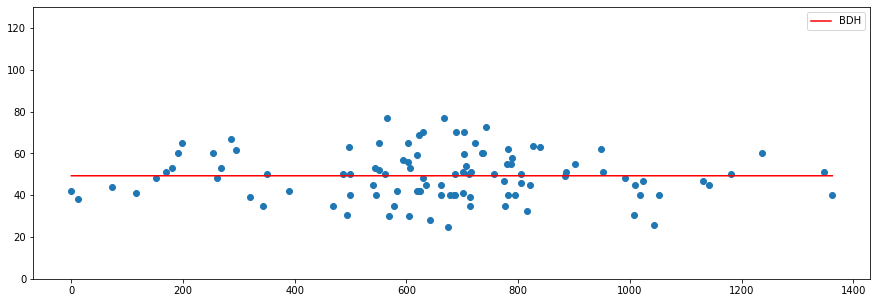

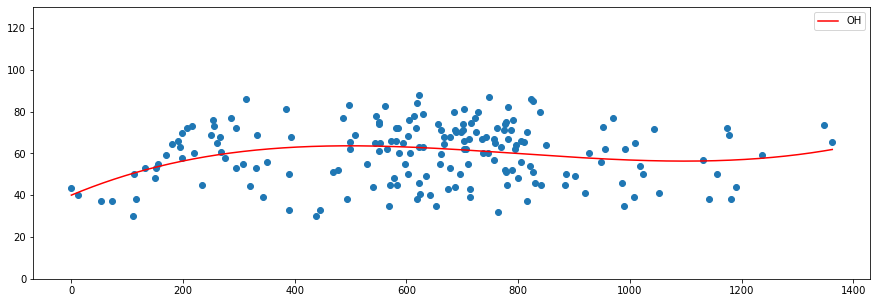

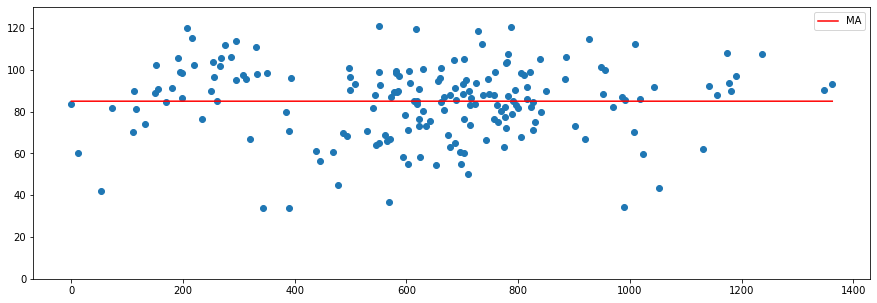

In [21]:
for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(total_rain)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    plt.ylim((0, 130))
    plt.scatter(data_array, rdt_array)
    
    coef = best_coeffs[crop + "_" + best_predict_degree[crop]]
    x_plot = np.linspace(0, data_array.max(), int(data_array.max() * 10))
    y_plot = np.array([best_intercepts[crop + "_" + best_predict_degree[crop]] for i in range(int(data_array.max() * 10))])
    if type(coef) != float:
        for param in range(len(coef)):
            y_plot += x_plot ** (len(coef) - param) * coef[param]
    
    plt.plot(x_plot, y_plot, color="red")
    plt.legend([crop], loc=1)

## DJ_0

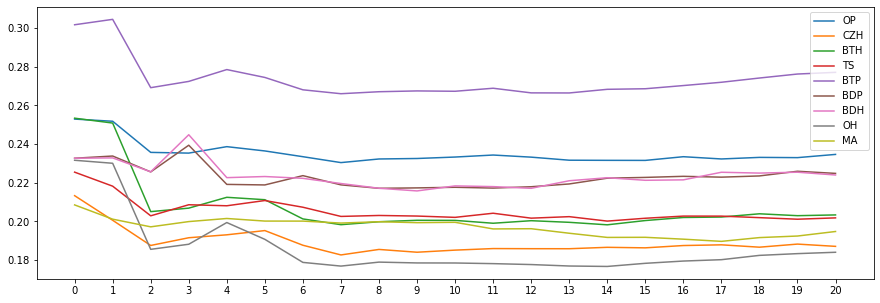

In [29]:
start = 0
end = 20
times = 1000
total_rad_0 = {}

rRMSE_degree = {}
coeffs = {}

init_x(total_rad_0, "DJ_0")

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(total_rad_0)

    test_degree_n(times)

draw()

In [30]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(start, end + 1):
        temp_list.append(rRMSE_degree[crop + "_" + str(i)])
    best_predict[crop + "_" + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP_7': 0.23042090846327903,
 'CZH_7': 0.1826407140203,
 'BTH_14': 0.1982243201160757,
 'TS_14': 0.20014601287015552,
 'BTP_7': 0.26606279875435423,
 'BDP_8': 0.21711998561126447,
 'BDH_9': 0.21575948094069836,
 'OH_14': 0.17668193644113023,
 'MA_17': 0.18966058547815867}

In [31]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP_7': array([ 1.70028710e-23, -2.59996450e-19,  1.30150531e-15, -2.13619102e-12,
        -1.72298554e-15, -8.44830534e-19, -2.89448060e-22]),
 'CZH_7': array([ 1.17332475e-23, -1.82394257e-19,  9.36248487e-16, -1.59771218e-12,
        -1.29186035e-15, -6.34897558e-19, -2.18143626e-22]),
 'BTH_14': array([-2.95970236e-49,  5.20016384e-45, -3.03209026e-41,  5.85705210e-38,
         4.38832424e-41,  2.06401768e-44,  7.80115064e-48,  2.59135243e-51,
         7.90189912e-55,  2.26539254e-58,  6.18102269e-62,  1.60489791e-65,
         3.85954163e-69,  7.50870652e-73]),
 'TS_14': array([ 3.86227951e-50, -6.07882394e-46,  3.17867051e-42, -5.55774791e-39,
        -4.15904242e-42, -1.95364735e-45, -7.37380550e-49, -2.44580917e-52,
        -7.44660708e-56, -2.13149302e-59, -5.80674949e-63, -1.50574007e-66,
        -3.61841778e-70, -7.04294472e-74]),
 'BTP_7': array([ 2.41008280e-23, -3.60835071e-19,  1.75792536e-15, -2.78510551e-12,
        -2.24925652e-15, -1.10357241e-18, -3.78691187e-22]),


In [32]:
best_intercepts = {}

for inter in intercepts:
    if inter in best_predict:
        best_intercepts[inter] = intercepts[inter]
        
best_intercepts

{'OP_7': 52.233982910284915,
 'CZH_7': 35.727763441096606,
 'BTP_7': 61.09680883899301,
 'BDP_8': 53.858899028775014,
 'BDH_9': 53.08168287879639,
 'BTH_14': 64.86818922002776,
 'TS_14': 24.89616096280119,
 'OH_14': 59.96945423828766,
 'MA_17': 94.04473523840069}

In [33]:
best_predict_degree = {}

for i in best_predict:
    name, degree = i.split("_")
    best_predict_degree[name] = degree

best_predict_degree

{'OP': '7',
 'CZH': '7',
 'BTH': '14',
 'TS': '14',
 'BTP': '7',
 'BDP': '8',
 'BDH': '9',
 'OH': '14',
 'MA': '17'}

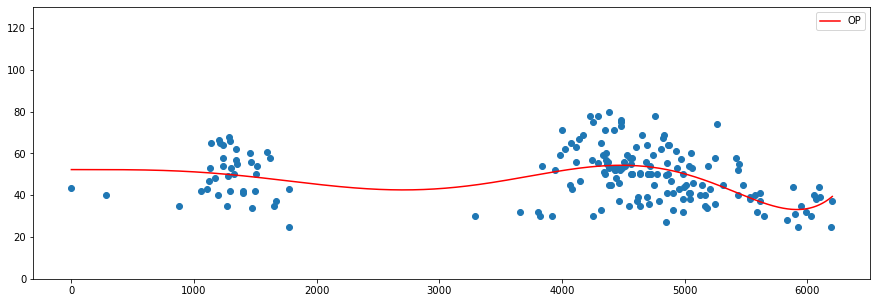

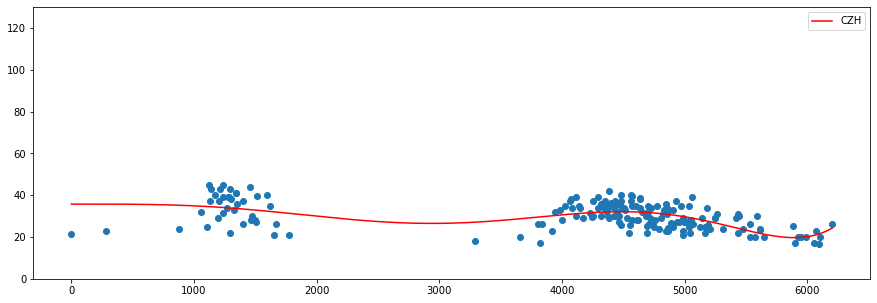

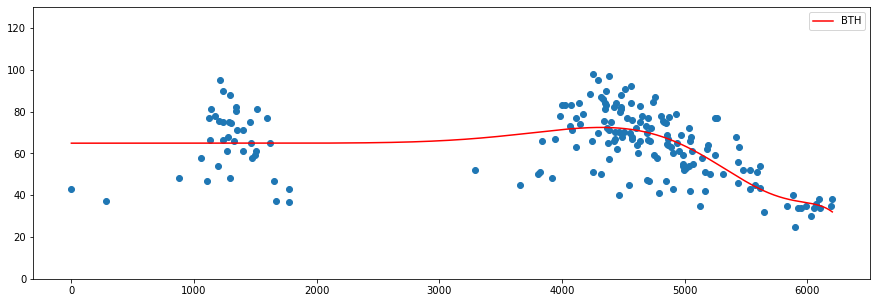

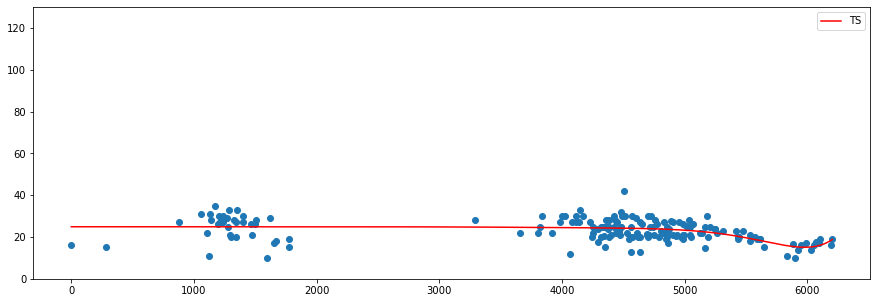

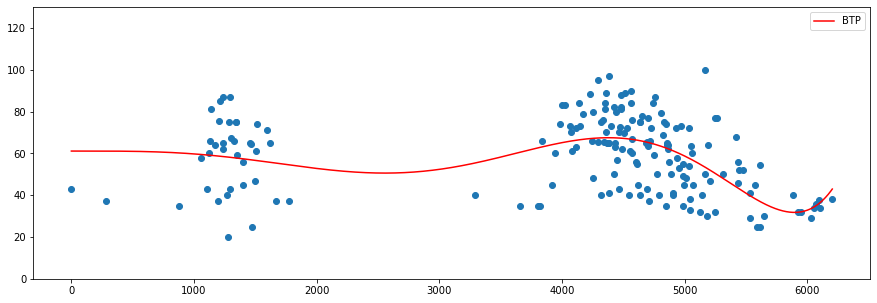

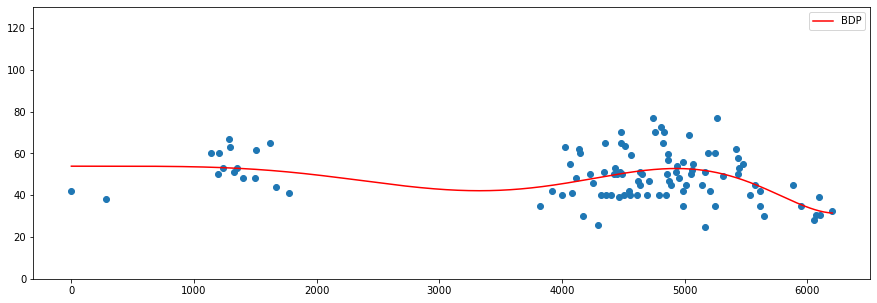

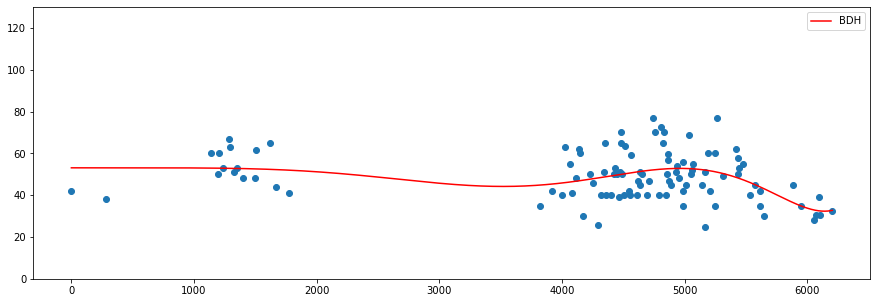

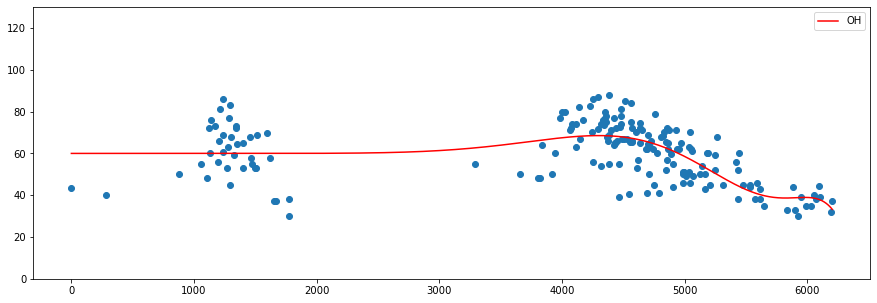

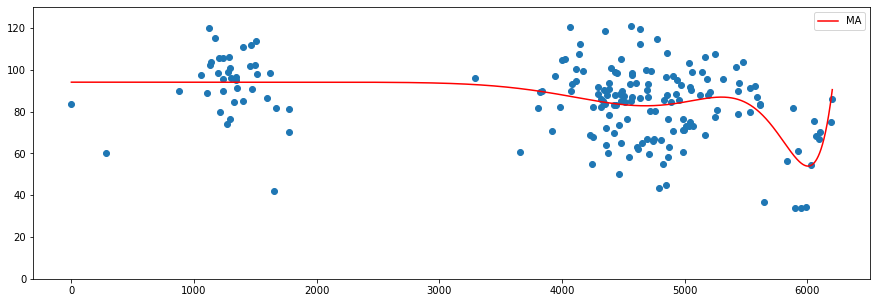

In [34]:
for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(total_rad_0)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    plt.ylim((0, 130))
    plt.scatter(data_array, rdt_array)
    
    coef = best_coeffs[crop + "_" + best_predict_degree[crop]]
    x_plot = np.linspace(0, data_array.max(), int(data_array.max() * 10))
    y_plot = np.array([best_intercepts[crop + "_" + best_predict_degree[crop]] for i in range(int(data_array.max() * 10))])
    if type(coef) != float:
        for param in range(len(coef)):
            y_plot += x_plot ** (len(coef) - param) * coef[param]
    
    plt.plot(x_plot, y_plot, color="red")
    plt.legend([crop], loc=1)

## DJ_6

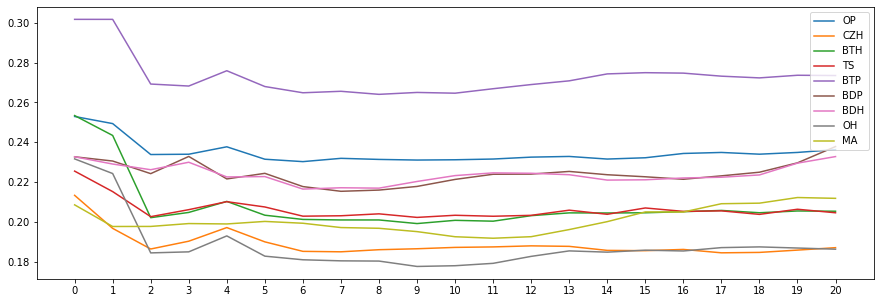

In [35]:
start = 0
end = 20
times = 1000
total_rad_6 = {}

rRMSE_degree = {}
coeffs = {}

init_x(total_rad_6, "DJ_6")

for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(total_rad_6)

    test_degree_n(times)

draw()

In [36]:
best_predict = {}

for crop in crops:
    temp_list = []
    for i in range(start, end + 1):
        temp_list.append(rRMSE_degree[crop + "_" + str(i)])
    best_predict[crop + "_" + str(temp_list.index(min(temp_list)))] = min(temp_list)

best_predict

{'OP_6': 0.23024660910655712,
 'CZH_17': 0.18441630332202902,
 'BTH_9': 0.19911794418937726,
 'TS_9': 0.20221452922486413,
 'BTP_8': 0.26406011638984195,
 'BDP_7': 0.21533293374934745,
 'BDH_6': 0.21644512241817473,
 'OH_9': 0.1775667586301965,
 'MA_11': 0.19174548546893552}

In [37]:
best_coeffs = {}

for coef in coeffs:
    if coef in best_predict:
        best_coeffs[coef] = coeffs[coef]
        
best_coeffs

{'OP_6': array([ 4.26629248e-19, -3.77182294e-15,  1.04735776e-11, -9.07262854e-09,
        -1.18492439e-11, -8.43827455e-15]),
 'CZH_17': array([ 1.38975464e-57, -1.59537101e-53,  6.12887185e-50, -7.88839255e-47,
        -8.95947839e-50, -6.38329359e-53, -3.65144717e-56, -1.83405452e-59,
        -8.45025601e-63, -3.66081032e-66, -1.51402812e-69, -6.03590407e-73,
        -2.33327498e-76, -8.76639100e-80, -3.18900279e-83, -1.09731065e-86,
        -3.16251122e-90]),
 'BTH_9': array([-2.33321228e-29,  2.65957838e-25, -9.99782857e-22,  1.22956317e-18,
         1.55500654e-21,  1.23638432e-24,  7.83460053e-28,  4.19000739e-31,
         1.72546831e-34]),
 'TS_9': array([ 4.99362710e-30, -4.73626990e-26,  1.47586664e-22, -1.54125057e-19,
        -1.94542747e-22, -1.54388341e-25, -9.76709612e-29, -5.21842832e-32,
        -2.14990604e-35]),
 'BTP_8': array([-3.87627708e-26,  5.00928439e-22, -2.08403544e-18,  2.78223609e-15,
         3.61046856e-18,  2.91663779e-21,  1.81686610e-24,  8.33567348e

In [38]:
best_intercepts = {}

for inter in intercepts:
    if inter in best_predict:
        best_intercepts[inter] = intercepts[inter]
        
best_intercepts

{'OP_6': 50.677850076437956,
 'BTH_9': 64.85416296368847,
 'TS_9': 24.938513093879724,
 'BTP_8': 57.19055087501094,
 'BDP_7': 53.88760561024189,
 'BDH_6': 56.29492130250526,
 'OH_9': 59.74477265981866,
 'CZH_17': 33.084918543466806,
 'MA_11': 94.52321980142037}

In [39]:
best_predict_degree = {}

for i in best_predict:
    name, degree = i.split("_")
    best_predict_degree[name] = degree

best_predict_degree

{'OP': '6',
 'CZH': '17',
 'BTH': '9',
 'TS': '9',
 'BTP': '8',
 'BDP': '7',
 'BDH': '6',
 'OH': '9',
 'MA': '11'}

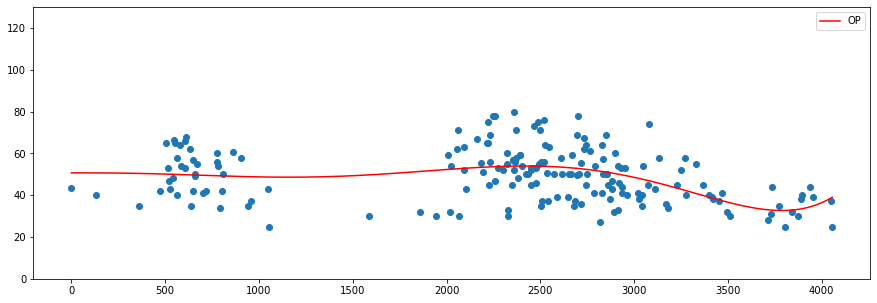

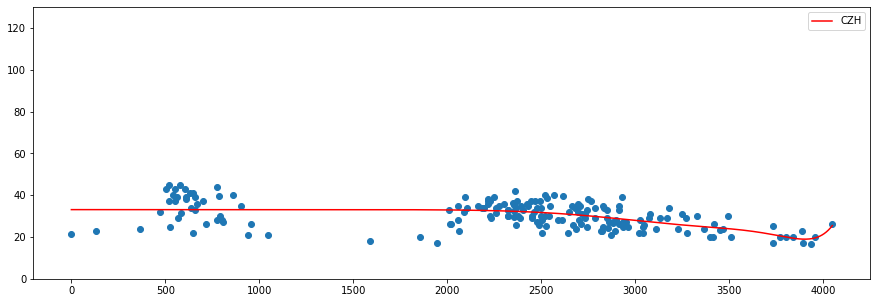

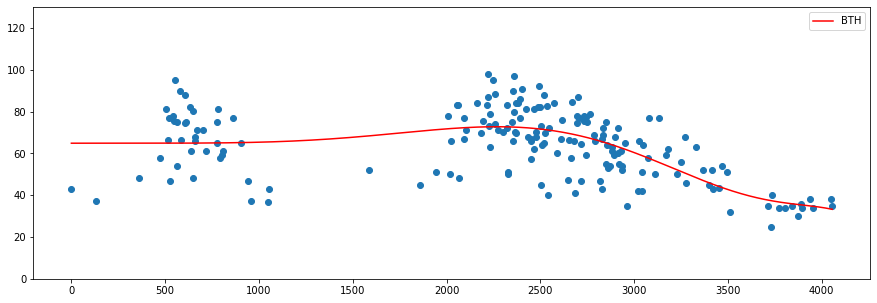

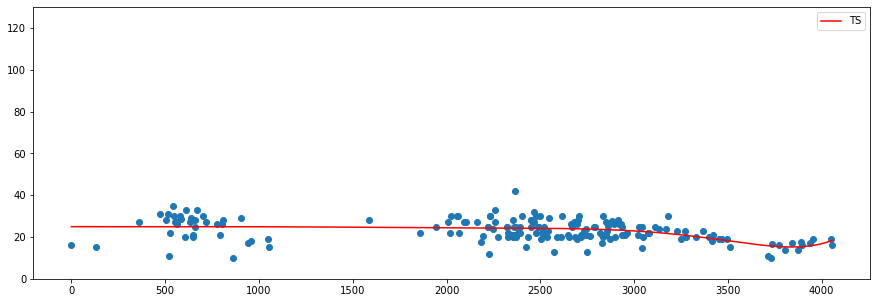

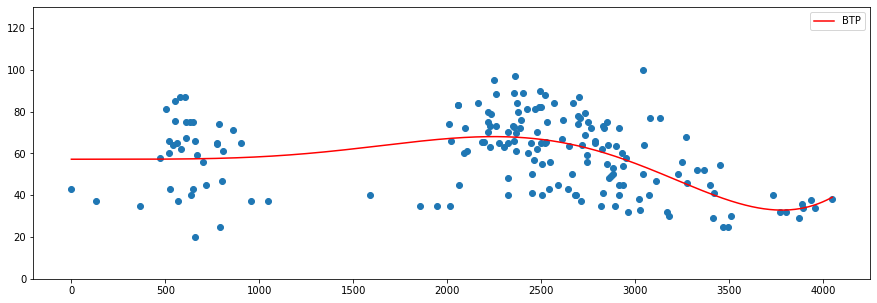

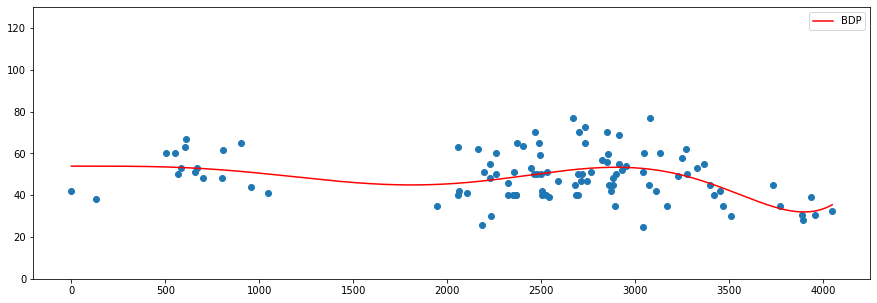

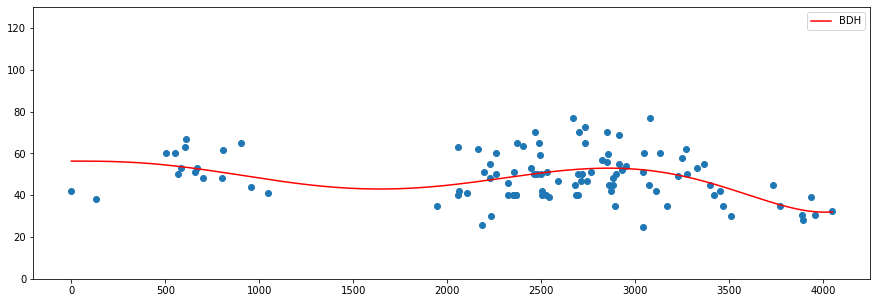

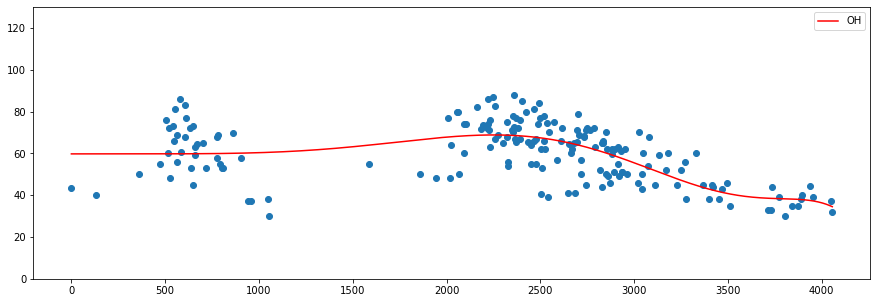

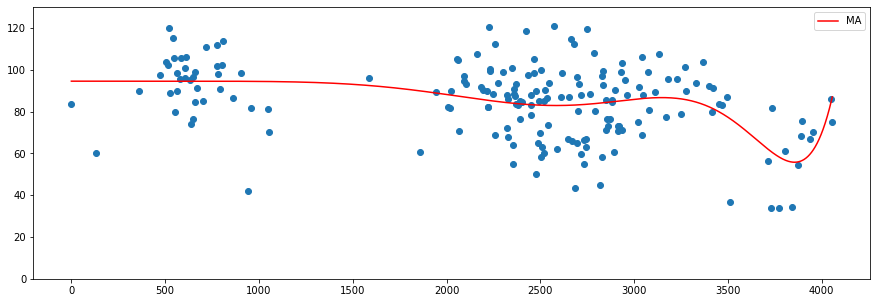

In [40]:
for crop in crops:
    total_rdt = {}

    data_array, rdt_array = init(total_rad_6)
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    plt.ylim((0, 130))
    plt.scatter(data_array, rdt_array)
    
    coef = best_coeffs[crop + "_" + best_predict_degree[crop]]
    x_plot = np.linspace(0, data_array.max(), int(data_array.max() * 10))
    y_plot = np.array([best_intercepts[crop + "_" + best_predict_degree[crop]] for i in range(int(data_array.max() * 10))])
    if type(coef) != float:
        for param in range(len(coef)):
            y_plot += x_plot ** (len(coef) - param) * coef[param]
    
    plt.plot(x_plot, y_plot, color="red")
    plt.legend([crop], loc=1)